In [ ]:
"""
Model Architecture + Baseline Loss
=============================================================

What you have:
- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).
- A simple baseline regression loss (SmoothL1 by default).

Expected I/O (very important):
- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).
- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].
- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.
- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).

Tasks:
1) Implement the Dataset + DataLoader to read images and JSON annotations.
2) Compute dataset mean/std and apply torchvision Normalize with those real stats.
3) Write the training/validation/test loops and metrics.
4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.
5) Add evaluation plots and an ablation plan (baseline FP32 vs QAT variants).

Notes:
- This file intentionally omits logging, schedulers, early stopping, and custom constraints.
- You may widen/deepen the model, but keep the 5-output head.
"""

'\nModel Architecture + Baseline Loss\n=============================================================\n\nWhat you have:\n- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).\n- A simple baseline regression loss (SmoothL1 by default).\n\nExpected I/O (very important):\n- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).\n- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].\n- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.\n- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).\n\nTasks:\n1) Implement the Dataset + DataLoader to read images and JSON annotations.\n2) Compute dataset mean/std and apply torchvision Normalize with those real stats.\n3) Write the training/validation/test loops and metrics.\n4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.\n5) Add evaluation plots and an ablation plan (baselin

In [1]:
from __future__ import annotations
import torch
import torch.nn as nn


In [2]:
import brevitas.nn as qnn
import brevitas.quant as quant
import torch.nn as nn


W1111 14:19:42.330000 15111 site-packages/torch/utils/cpp_extension.py:117] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [6]:
class EllipseRegressionModel(nn.Module):
    """Small CNN for regressing (cx, cy, l1, l2, l3) from 20×20 RGB.

    Design:
      - 4× (Conv → BN → LeakyReLU → MaxPool2d(2))
      - Flatten → 2× Linear → 5-dim output

    With 20×20 input, four 2× pools map features to 1×1.
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2)
        self.act = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 5)  # (cx, cy, l1, l2, l3) — l* expected normalized by /400 in targets

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.act(self.bn1(self.conv1(x))))  # 20→10
        x = self.pool(self.act(self.bn2(self.conv2(x))))  # 10→5
        x = self.pool(self.act(self.bn3(self.conv3(x))))  # 5→2
        x = self.pool(self.act(self.bn4(self.conv4(x))))  # 2→1
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc_out(x)
        return out

In [4]:
class BaselineRegressionLoss(nn.Module):
    """Simple baseline loss for regression.

    - Uses SmoothL1 by default (robust, stable).
    - Assumes targets already normalized (l1,l2,l3 divided by 400 before batching).
    """

    def __init__(self, kind: str = "smoothl1"):
        super().__init__()
        if kind.lower() == "mse":
            self.crit = nn.MSELoss()
        else:
            self.crit = nn.SmoothL1Loss()

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.crit(preds, targets)

In [ ]:
# -----------------------------
# Minimal usage example (sketch)
# -----------------------------
# import torch.optim as optim
# model = EllipseRegressionModel().to(device)
# loss_fn = BaselineRegressionLoss(kind="smoothl1").to(device)
# opt = optim.Adam(model.parameters(), lr=1e-3)
# for imgs, targets in train_loader:  # student must implement DataLoader
#     imgs, targets = imgs.to(device), targets.to(device)
#     opt.zero_grad()
#     preds = model(imgs)
#     loss = loss_fn(preds, targets)
#     loss.backward()
#     opt.step()
#
# QAT:
# - Fuse (conv,bn,act) where applicable
# - Set qconfig (torch.ao.quantization.get_default_qat_qconfig)
# - prepare_qat(model) → train → convert(model) for inference

In [6]:

#  Dataset + Dataloader


from dataset import EllipseDataset       # make sure dataset.py is in the same folder as your notebook
from dataloader import create_dataloaders
from torchvision import transforms

#  Update these paths for your local setup
images_dir = "/home/hritik/Desktop/Hritik/Files/ElGenV2_Ellipses_GBB_1M_v1/Ellipses"
annotations_path = "/home/hritik/Desktop/Hritik/Files/ElGenV2_Ellipses_GBB_1M_v1/annotations.json"

#  Transform: Resize to 20×20 and convert to 1-channel (grayscale)
transform = transforms.Compose([
    transforms.Resize((20, 20)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

#  Create dataset and dataloaders
dataset = EllipseDataset(images_dir=images_dir, annotations_path=annotations_path, transform=transform)
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size=64, num_workers=4)

print(f"Dataset loaded successfully with {len(dataset)} samples.")
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")


Dataset loaded successfully with 1000000 samples.
Train: 800000, Val: 100000, Test: 100000


In [ ]:
# Device selection (safe GPU/CPU auto-fallback)

import torch


def select_device(min_arch: int = 70) -> torch.device:
    """Return torch.device('cuda') if a usable CUDA GPU exists and meets the
    minimum compute capability (e.g. 70 -> sm_70). Otherwise return CPU.
    """
    if not torch.cuda.is_available():
        return torch.device('cpu')
    try:
        prop = torch.cuda.get_device_properties(0)
        compute = prop.major * 10 + prop.minor
        if compute >= min_arch:
            return torch.device('cuda')
        print(f"GPU {prop.name} compute capability {prop.major}.{prop.minor} < required {min_arch/10:.1f}; using CPU")
        return torch.device('cpu')
    except Exception:
        # fallback to CPU if querying properties fails
        return torch.device('cpu')


def move_batch_to_device(batch: dict, device: torch.device) -> dict:
    """Move all torch.Tensor values in batch (dict) to device; leave others unchanged."""
    return {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}


# Select device and print recommended pin_memory flag
device = select_device()
print('Selected device ->', device)
pin_memory = (device.type == 'cuda')
print('pin_memory recommended =', pin_memory)


# Safe smoke-check: move model and one batch to device, verify shapes before inference
# This check is defensive: it will not error if cells are run out-of-order.
if 'train_loader' not in globals():
    print('train_loader is not defined. Run the Dataset + Dataloader cell first. Skipping smoke-check.')
else:
    # Only attempt model forward if the model class is defined
    if 'EllipseRegressionModel' in globals():
        try:
            model = EllipseRegressionModel().to(device)
            model.eval()

            # Grab a batch from train_loader
            batch = next(iter(train_loader))

            # Inspect raw shapes before moving
            print('Raw batch shapes: image', batch['image'].shape, 'params', batch['params'].shape)

            # Move tensors in batch to device
            batch = move_batch_to_device(batch, device)
            images = batch['image']
            targets = batch['params']

            # Final device/shape checks
            print('Moved to device:', device)
            print('images device:', images.device, 'targets device:', targets.device)
            print('images shape:', images.shape, 'targets shape:', targets.shape)

            # Optional forward pass check
            with torch.no_grad():
                outputs = model(images)
            print('Forward OK — outputs shape:', outputs.shape)
        except Exception as e:
            import traceback
            print('Error during smoke-check:')
            traceback.print_exc()
    else:
        print('EllipseRegressionModel is not defined. Run the model-definition cell before this smoke-check.')


Selected device -> cpu
pin_memory recommended = False
Raw batch shapes: image torch.Size([64, 1, 20, 20]) params torch.Size([64, 5])
Moved to device: cpu
images device: cpu targets device: cpu
images shape: torch.Size([64, 1, 20, 20]) targets shape: torch.Size([64, 5])
Forward OK — outputs shape: torch.Size([64, 5])
Raw batch shapes: image torch.Size([64, 1, 20, 20]) params torch.Size([64, 5])
Moved to device: cpu
images device: cpu targets device: cpu
images shape: torch.Size([64, 1, 20, 20]) targets shape: torch.Size([64, 5])
Forward OK — outputs shape: torch.Size([64, 5])


In [8]:
# Helper cell: compute ranges (min/max) for targets before normalization",
# It prefers `train_loader` (batches) if available, otherwise falls back to iterating `dataset`.
# Prints both the dataset-returned (normalized) ranges and denormalized ranges for l1,l2,l3 (×400).

import numpy as np
import torch

def _gather_all_targets():
    if 'train_loader' in globals():
        print('Collecting targets from train_loader (batched)...')
        parts = []
        for batch in train_loader:
            params = batch['params']
            if isinstance(params, torch.Tensor):
                parts.append(params.cpu().numpy())
            else:
                parts.append(np.asarray(params))
        return np.concatenate(parts, axis=0)
    elif 'dataset' in globals():
        print('Collecting targets by iterating dataset (may be slower)...')
        parts = []
        try:
            from tqdm import tqdm
            iterator = range(len(dataset))
            for i in tqdm(iterator, desc='reading dataset'):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        except Exception:
            # fallback without tqdm
            for i in range(len(dataset)):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        return np.stack(parts, axis=0)
    else:
        raise RuntimeError('Neither `train_loader` nor `dataset` found in globals. Run the Dataset + Dataloader cell first.')

try:
    all_params = _gather_all_targets()
    assert all_params.ndim == 2 and all_params.shape[1] == 5, f'unexpected params shape: {all_params.shape}'

    names = ['cx', 'cy', 'l1', 'l2', 'l3']

    mins = all_params.min(axis=0)
    maxs = all_params.max(axis=0)
    means = all_params.mean(axis=0)
    stds = all_params.std(axis=0)

    print('\nNormalized ranges:')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins[i]:.6g}, max={maxs[i]:.6g}, mean={means[i]:.6g}, std={stds[i]:.6g}')

    # Denormalize l1,l2,l3 by multiplying by 400 (common convention used in this project)
    denorm = all_params.copy()
    denorm[:, 2:5] = denorm[:, 2:5] * 400.0
    mins_d = denorm.min(axis=0)
    maxs_d = denorm.max(axis=0)
    means_d = denorm.mean(axis=0)
    stds_d = denorm.std(axis=0)

    print('\nDenormalized ranges (l1,l2,l3 multiplied by 400):')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins_d[i]:.6g}, max={maxs_d[i]:.6g}, mean={means_d[i]:.6g}, std={stds_d[i]:.6g}')

except Exception as e:
    print('Failed to compute target ranges:', e)
    raise


Normalized ranges:
   cx: min=5.33106, max=34.6247, mean=20.0028, std=4.61721
   cy: min=5.36937, max=34.7364, mean=20.0086, std=4.60996
   l1: min=25.0399, max=393.264, mean=136.201, std=59.6002
   l2: min=25.0031, max=395.514, mean=136.334, std=59.6104
   l3: min=-185.593, max=185.856, mean=-0.033421, std=46.0062

Denormalized ranges (l1,l2,l3 multiplied by 400):
   cx: min=5.33106, max=34.6247, mean=20.0028, std=4.61721
   cy: min=5.36937, max=34.7364, mean=20.0086, std=4.60996
   l1: min=10016, max=157305, mean=54480.6, std=23840.6
   l2: min=10001.3, max=158205, mean=54534.3, std=23844.2
   l3: min=-74237.2, max=74342.5, mean=-13.3684, std=18403


Image ID: 222352
cx=16.28, cy=19.39
l1=46.503, l2=98.055, l3=-18.802
Derived: a=10.826, b=nan, θ=-144.21°



/tmp/ipykernel_3996/1425350600.py:25: RuntimeWarning: invalid value encountered in sqrt
  a, b = np.sqrt(eigenvalues)


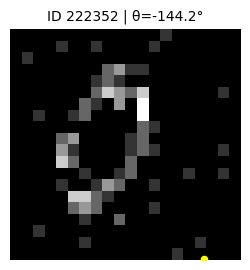

Image ID: 987363
cx=18.14, cy=22.89
l1=227.221, l2=228.564, l3=-4.239
Derived: a=19.175, b=nan, θ=-148.43°



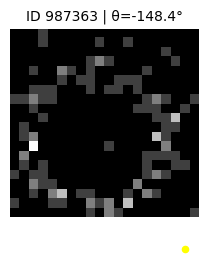

Image ID: 580155
cx=22.59, cy=20.28
l1=132.558, l2=140.038, l3=9.601
Derived: a=14.967, b=nan, θ=-146.85°



ValueError: need at least one array to concatenate

<Figure size 300x300 with 1 Axes>

Image ID: 680353
cx=12.02, cy=20.75
l1=67.752, l2=123.732, l3=-28.560
Derived: a=12.344, b=nan, θ=-145.63°



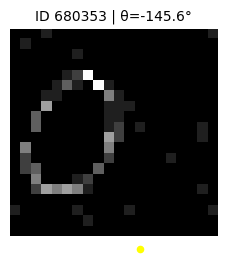

Image ID: 911790
cx=26.29, cy=20.79
l1=127.269, l2=129.932, l3=-4.141
Derived: a=14.393, b=nan, θ=-148.41°



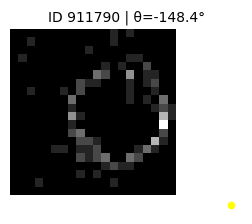

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

#  Function to compute a,b,theta from covariance matrix 
def ellipse_from_covariance(l1, l2, l3):
    """
    Given covariance matrix elements (l1, l2, l3),
    return (a, b, theta):
    - a: semi-major axis length
    - b: semi-minor axis length
    - theta: orientation angle in degrees
    """
    cov = np.array([[l1, l2],
                    [l2, l3]])

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Sort eigenvalues descending
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    a, b = np.sqrt(eigenvalues)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    return a, b, theta


#  Visualize few random samples 
num_samples = 5  # how many ellipses to visualize
indices = random.sample(range(len(dataset)), num_samples)

for idx in indices:
    sample = dataset[idx]
    img = sample["image"].permute(1, 2, 0).numpy()
    params = sample["params"].numpy()
    cx, cy = params[0], params[1]
    l1, l2, l3 = params[2], params[3], params[4]

    a, b, theta = ellipse_from_covariance(l1, l2, l3)

    print(f"Image ID: {sample['image_id']}")
    print(f"cx={cx:.2f}, cy={cy:.2f}")
    print(f"l1={l1:.3f}, l2={l2:.3f}, l3={l3:.3f}")
    print(f"Derived: a={a:.3f}, b={b:.3f}, θ={theta:.2f}°\n")

    # Plot image + ellipse outline 
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img, cmap="gray")
    ax.set_title(f"ID {sample['image_id']} | θ={theta:.1f}°", fontsize=10)

    # Create the ellipse outline using derived values
    ellipse = patches.Ellipse(
        (cx, cy), width=2*a, height=2*b, angle=theta,
        edgecolor="red", facecolor="none", linewidth=2
    )
    ax.add_patch(ellipse)
    ax.scatter(cx, cy, color="yellow", s=20)  # mark center
    ax.set_axis_off()
    plt.show()


In [10]:

#  Baseline Inference  (GPU if available, else CPU)

import torch
import sys

# Determine device: prefer an existing `device` or `select_device()` helper if present,
# otherwise choose CUDA if available else CPU. This prints informative messages.
_device = globals().get('device', None)
if _device is not None:
    device = _device
else:
    sel = globals().get('select_device', None)
    if callable(sel):
        try:
            device = sel()
        except Exception as e:
            print('select_device() failed, falling back to torch defaults:', e)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        # No helper: prefer CUDA if available. Print device properties when possible.
        if torch.cuda.is_available():
            try:
                prop = torch.cuda.get_device_properties(0)
                print(f'CUDA available: {prop.name} compute {prop.major}.{prop.minor}')
            except Exception as e:
                print('Could not query CUDA device properties:', e)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

print(f'Using device: {device}')

# Initialize model and move to the selected device
model = EllipseRegressionModel().to(device)
model.eval()

# Load a small batch and move it to the selected device
batch = next(iter(train_loader))
batch = move_batch_to_device(batch, device)
images = batch['image']
targets = batch['params']

# Run inference
with torch.no_grad():
    outputs = model(images)

print(' Inference ran successfully!')
print('Predictions shape:', outputs.shape)
print('Sample prediction:', outputs[0])
print('Sample target:', targets[0])


Using device: cpu
 Inference ran successfully!
Predictions shape: torch.Size([64, 5])
Sample prediction: tensor([ 0.0170,  0.0050, -0.0229,  0.0260, -0.0020])
Sample target: tensor([ 26.1694,  28.2286,  32.9423, 104.0209,  -3.0429])


Evaluation will run on device: cpu
MAE per output (cx,cy,l1,l2,l3): [20.017419815063477, 20.01820945739746, 136.25563049316406, 136.4163055419922, 33.98832702636719]
RMSE per output (cx,cy,l1,l2,l3): [20.54467010498047, 20.541061401367188, 148.75189208984375, 148.85174560546875, 46.08515548706055]
Mean MAE: 69.33917999267578 Mean RMSE: 76.95491027832031
Denorm MAE (l1,l2,l3) [units]: [54502.25, 54566.5234375, 13595.330078125]
Denorm RMSE (l1,l2,l3) [units]: [59500.765625, 59540.69140625, 18434.0625]

First 5 examples (pred -> target):
[0] pred: [-0.04291318 -0.02083773  0.02174505 -0.00899274 -0.03306526]  target: [ 20.11696   23.309984 244.50993  166.78671   15.523792]
[1] pred: [-0.04355235 -0.0209117   0.0222354  -0.00956728 -0.03384896]  target: [ 11.818662  14.407217  79.66689  124.585785  -8.897466]
[2] pred: [-0.04350438 -0.02092218  0.02249984 -0.0091241  -0.03398627]  target: [ 16.714422  24.783396 117.24626  121.02411    4.126909]
[3] pred: [-0.04326163 -0.02068531  0.0229520

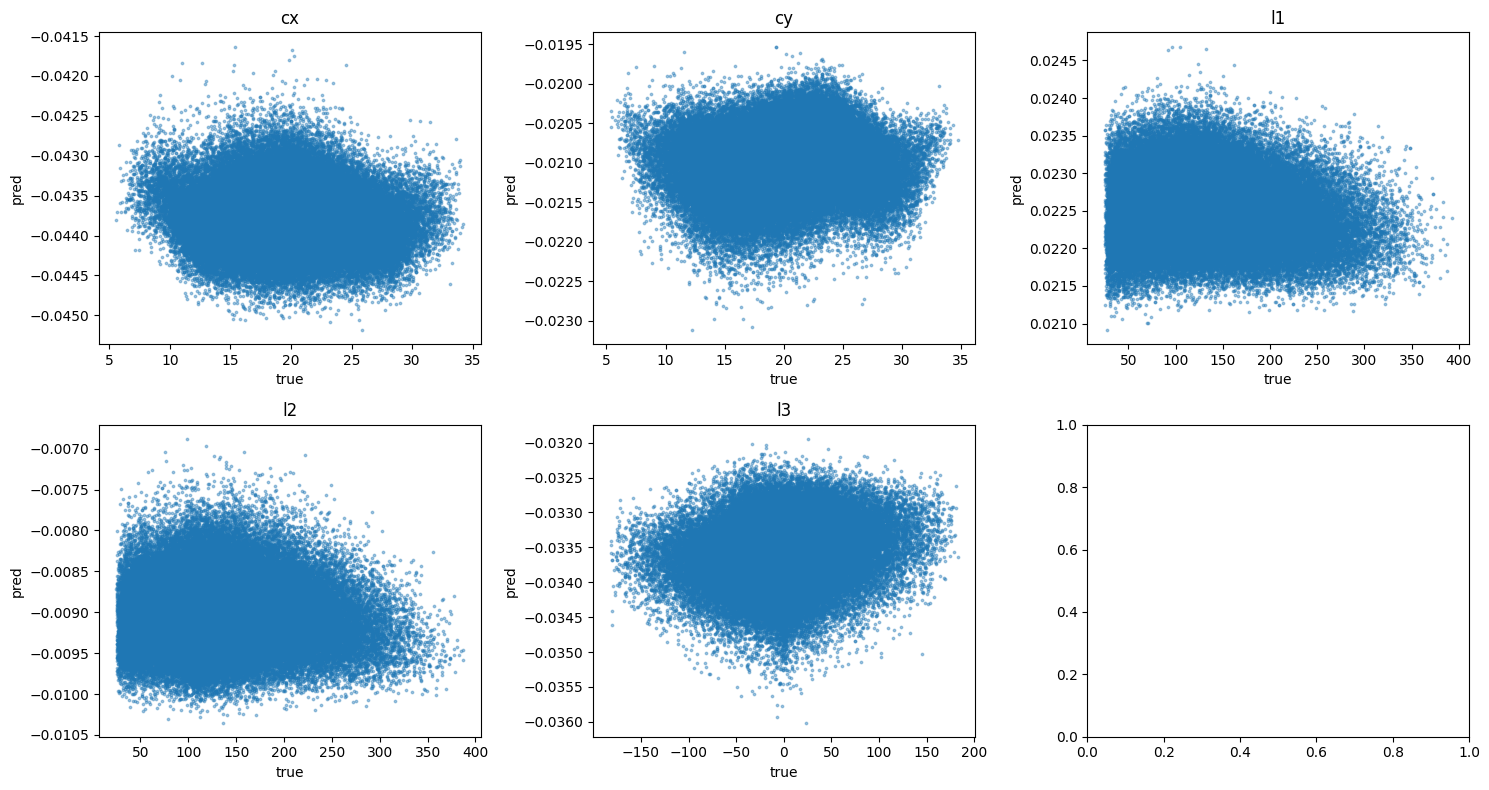

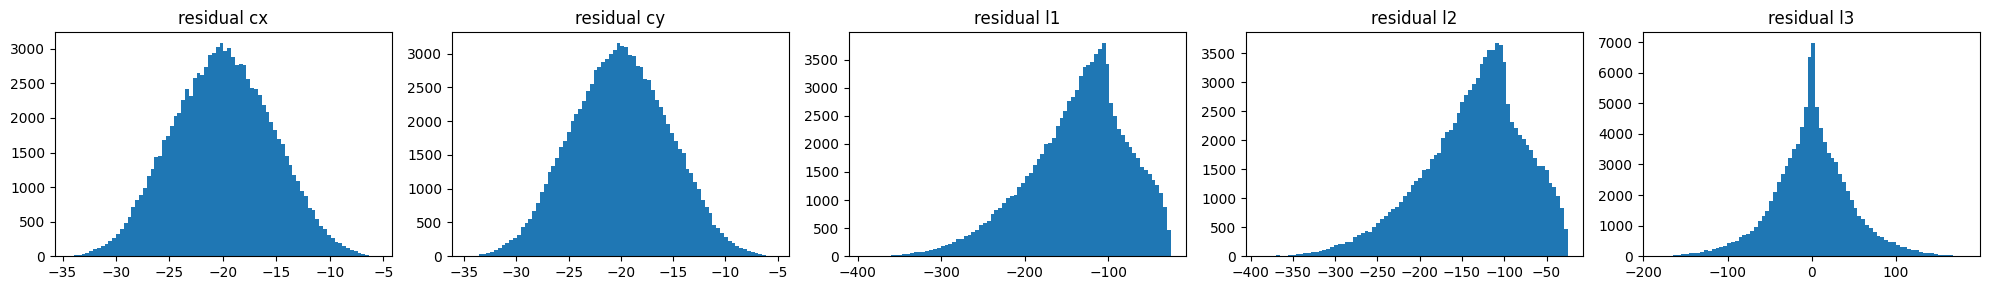

Evaluation complete.


In [11]:
# Evaluation: MAE / RMSE + diagnostic plots
# Runs the model over `val_loader` and prints per-output and overall metrics.
import torch
import numpy as np

# Determine device (prefer existing `device` or fall back)
device = globals().get('device') if globals().get('device', None) is not None else (select_device() if globals().get('select_device', None) else (torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
print('Evaluation will run on device:', device)

model = EllipseRegressionModel().to(device)
model.eval()

# Collect predictions and targets (keep on CPU to reduce GPU memory)
preds_list = []
tgt_list = []
with torch.no_grad():
    for batch in val_loader:
        batch = move_batch_to_device(batch, device)
        out = model(batch['image'])
        preds_list.append(out.cpu())
        tgt_list.append(batch['params'].cpu())

preds = torch.cat(preds_list, dim=0)
tgt = torch.cat(tgt_list, dim=0)

# Per-output metrics
diff = preds - tgt
mae_per = torch.mean(diff.abs(), dim=0)
rmse_per = torch.sqrt(torch.mean(diff**2, dim=0))
print('MAE per output (cx,cy,l1,l2,l3):', mae_per.tolist())
print('RMSE per output (cx,cy,l1,l2,l3):', rmse_per.tolist())
print('Mean MAE:', float(mae_per.mean()), 'Mean RMSE:', float(rmse_per.mean()))

# If l1/l2/l3 were normalized by 400 in the dataset, show denormalized metrics for those outputs
try:
    # assume normalization used: l1,l2,l3 divided by 400
    denorm_preds = preds.clone()
    denorm_tgt = tgt.clone()
    denorm_preds[:,2:5] *= 400.0
    denorm_tgt[:,2:5] *= 400.0
    denorm_diff = denorm_preds - denorm_tgt
    denorm_mae = torch.mean(denorm_diff.abs(), dim=0)
    denorm_rmse = torch.sqrt(torch.mean(denorm_diff**2, dim=0))
    print('Denorm MAE (l1,l2,l3) [units]:', denorm_mae[2:5].tolist())
    print('Denorm RMSE (l1,l2,l3) [units]:', denorm_rmse[2:5].tolist())
except Exception:
    pass

# Print a small table of samples: true vs pred for first 5 examples
n_show = min(5, preds.shape[0])
print(f'\nFirst {n_show} examples (pred -> target):')
for i in range(n_show):
    print(f'[{i}] pred:', preds[i].numpy(), ' target:', tgt[i].numpy())

# Diagnostic plots (scatter + residual histograms) if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import math
    preds_np = preds.numpy()
    tgt_np = tgt.numpy()
    # Scatter for cx and cx residuals
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    labels = ['cx', 'cy', 'l1', 'l2', 'l3']
    for j in range(5):
        axes[j].scatter(tgt_np[:, j], preds_np[:, j], s=3, alpha=0.4)
        axes[j].set_title(labels[j])
        axes[j].set_xlabel('true')
        axes[j].set_ylabel('pred')
    plt.tight_layout()
    plt.show()
    # Residual histograms for each output (include cx and cy as well)
    fig2, axes2 = plt.subplots(1, 5, figsize=(20, 3))
    for k in range(5):
        axes2[k].hist((preds_np[:, k]-tgt_np[:, k]), bins=80)
        axes2[k].set_title(f'residual {labels[k]}')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Matplotlib unavailable or plotting failed:', e)

print('Evaluation complete.')


In [36]:

#  FP32 TRAINING LOOP 

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Step: Device selection (safe fallback)
GPU_MIN_ARCH = globals().get('GPU_MIN_ARCH', 70)
try:
    device = select_device(min_arch=GPU_MIN_ARCH)
except Exception as e:
    print('select_device() unavailable or failed, using torch default:', e)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

globals()['device'] = device
print("Using device:", device)

# Step: Model and Loss
model = EllipseRegressionModel().to(device)

# Use SmoothL1Loss if available, else fallback to MSELoss
try:
    loss_fn = nn.SmoothL1Loss()
    loss_name = "SmoothL1Loss"
except AttributeError:
    loss_fn = nn.MSELoss()
    loss_name = "MSELoss"

loss_fn = loss_fn.to(device)
print("Using loss:", loss_name)

# Step: Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Reduce learning rate when validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
if hasattr(scheduler, 'verbose'):
    scheduler.verbose = True  # only works on newer PyTorch versions

# Step: Training parameters
num_epochs = 150
best_val_loss = float('inf')
best_epoch = 0

print("\n Starting FP32 training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    #  Training Loop 
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = batch['image'].to(device)
        targets = batch['params'].to(device)

        # Normalize covariance matrix terms (l1, l2, l3)
        targets_norm = targets.clone()
        targets_norm[:, 2:] /= 400.0

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, targets_norm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    #  Validation Loop
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            targets = batch['params'].to(device)

            tgt_norm = targets.clone()
            tgt_norm[:, 2:] /= 400.0

            preds = model(images)
            vloss = loss_fn(preds, tgt_norm)
            val_loss_total += vloss.item() * images.size(0)

    avg_val_loss = val_loss_total / len(val_loader.dataset)

    # Scheduler update (adjust learning rate)
    scheduler.step(avg_val_loss)
    print(f"→ Scheduler adjusted LR: {optimizer.param_groups[0]['lr']:.2e}")

    #  Epoch Summary 
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Save best model 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "ellipse_fp32_best.pth")
        print(f" Saved best model at epoch {best_epoch} (val loss {best_val_loss:.6f})")

print(f"\n Training complete! Best val loss {best_val_loss:.6f} at epoch {best_epoch}.")


GPU NVIDIA GeForce MX330 compute capability 6.1 < required 7.0; using CPU
Using device: cpu
Using loss: SmoothL1Loss

 Starting FP32 training...



Epoch 1/150:   1%|          | 116/12500 [00:06<11:00, 18.76it/s]


KeyboardInterrupt: 

In [12]:

# Cell: Save FP32 Trained Model


# Save final model (last epoch)
torch.save(model.state_dict(), "ellipse_fp32_final.pth")
print("FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'")



FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'


In [13]:
#  Cell: Load FP32 Model for Inference (with target normalization)

import torch

# Define the model architecture (must match training)
model = EllipseRegressionModel()

# Load saved weights
checkpoint_path = "ellipse_fp32_best.pth"  # or "ellipse_fp32_final.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # device = 'cpu' or 'cuda'

# Set model to evaluation mode
model.eval()

print(f"FP32 model loaded from '{checkpoint_path}' and ready for inference.")

# Quick inference test on one batch 
batch = next(iter(test_loader))  # use your test DataLoader

images = batch["image"].to(device)
targets = batch["params"].to(device)

# 🔹 Normalize l1, l2, l3 of the targets (same scaling used during training)
targets[:, 2:] = targets[:, 2:] / 400.0

# Run inference
with torch.no_grad():
    preds = model(images)

# Display results 
print("Predictions shape:", preds.shape)
print("\nFirst 5 predictions (normalized):")
print(preds[:5])

print("\nFirst 5 targets (normalized):")
print(targets[:5])

# Optional: Mean absolute difference just for a quick sanity check
mae = torch.mean(torch.abs(preds - targets), dim=0)
print("\nQuick MAE per parameter (cx, cy, l1, l2, l3):", mae.cpu().numpy())


FP32 model loaded from 'ellipse_fp32_best.pth' and ready for inference.
Predictions shape: torch.Size([64, 5])

First 5 predictions (normalized):
tensor([[19.9364, 20.6175,  0.5067,  0.4835,  0.0441],
        [27.3637, 17.1454,  0.2658,  0.1353, -0.0751],
        [18.8130, 29.1883,  0.6455,  0.2391,  0.2381],
        [22.9421, 20.8735,  0.3580,  0.4059, -0.0826],
        [20.7428, 21.9626,  0.5144,  0.4245, -0.1029]])

First 5 targets (normalized):
tensor([[ 1.9458e+01,  2.0255e+01,  4.8517e-01,  5.0830e-01,  2.6108e-02],
        [ 2.7302e+01,  1.7090e+01,  2.7061e-01,  1.1594e-01, -7.4774e-02],
        [ 1.8756e+01,  2.9260e+01,  6.6586e-01,  2.0957e-01,  2.2754e-01],
        [ 2.3287e+01,  2.1523e+01,  3.7777e-01,  3.7948e-01, -8.3742e-02],
        [ 2.0707e+01,  2.1843e+01,  5.3573e-01,  4.0925e-01, -9.3996e-02]])

Quick MAE per parameter (cx, cy, l1, l2, l3): [0.13357492 0.14016615 0.01271409 0.01298899 0.00968321]


Evaluating FP32 model: 100%|██████████| 1563/1563 [00:40<00:00, 38.37it/s]



Median magnitudes (pred l1,l2,l3): [0.32091823 0.32468334 0.06364962]
Median magnitudes (tgt  l1,l2,l3): [128.30324 128.23422  25.63295]
-> predictions l looks normalized (median 0.250); applying *400.0 denorm factor.
-> targets l looks already denormalized (median 99.224); leaving as-is.
Median cx pred=20.022, tgt=20.034

MAE per output (cx, cy, l1, l2, l3) [denorm units]: [0.15032402 0.15054163 5.16706    5.25644    4.229676  ]
RMSE per output (cx, cy, l1, l2, l3) [denorm units]: [0.19483373 0.19559334 6.894822   6.96663    5.5772343 ]
Mean MAE: 2.990808, Mean RMSE: 3.965823



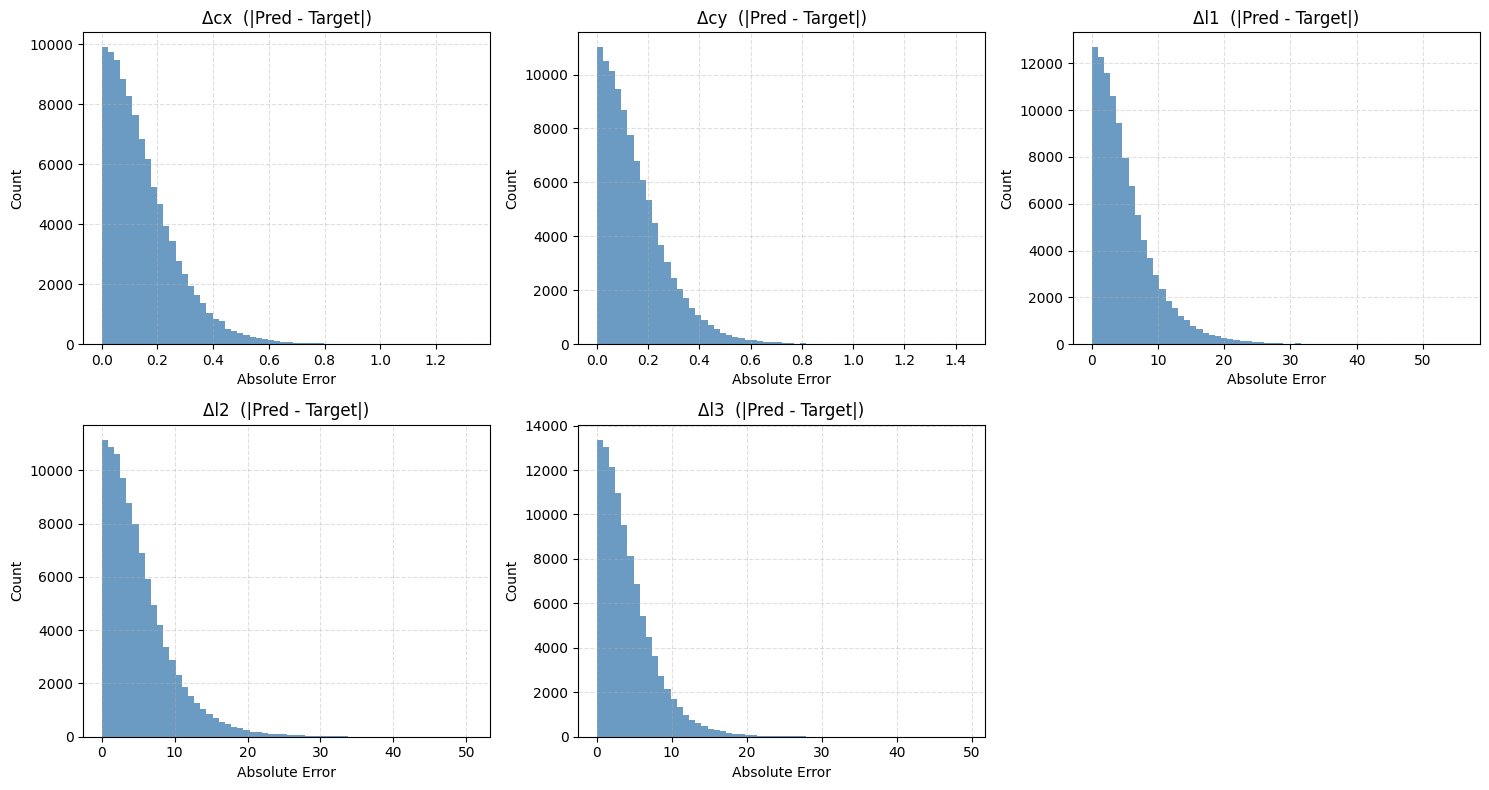

Δcx: mean Δ=0.150, std=0.124, max Δ=1.328
Δcy: mean Δ=0.151, std=0.125, max Δ=1.442
Δl1: mean Δ=5.167, std=4.565, max Δ=55.842
Δl2: mean Δ=5.256, std=4.572, max Δ=50.715
Δl3: mean Δ=4.230, std=3.635, max Δ=49.286


In [59]:

# Cell: Evaluate FP32 Model + Δ (Delta) Histograms


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DENORM = 400.0  # the factor used during training: targets[:,2:] /= DENORM

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets (raw from model and dataset)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating FP32 model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)   # dataset-provided values (likely raw)
        preds = model(images)                  # model outputs (likely normalized for l1,l2,l3)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Diagnostics: inspect typical magnitudes for covariance components
pred_l_med = np.median(np.abs(all_preds[:, 2:]), axis=0)
tgt_l_med = np.median(np.abs(all_targets[:, 2:]), axis=0)
print("Median magnitudes (pred l1,l2,l3):", pred_l_med)
print("Median magnitudes (tgt  l1,l2,l3):", tgt_l_med)

# Heuristic to decide if values are normalized (≈O(1)) or already denormalized (>>1)
def maybe_denorm(arr, name):
    """If arr's median magnitude is small (<=5), assume it's normalized and denorm it."""
    med = np.median(np.abs(arr))
    if med <= 5.0:
        print(f"-> {name} looks normalized (median {med:.3f}); applying *{DENORM} denorm factor.")
        return arr * DENORM, True
    else:
        print(f"-> {name} looks already denormalized (median {med:.3f}); leaving as-is.")
        return arr, False

# Apply detection & denormalization for covariance parts separately for preds & targets
# Work on copies to avoid accidental double multiplication
preds_work = all_preds.copy()
targs_work = all_targets.copy()

# Denormalize l1,l2,l3 if needed
preds_work[:, 2:], pred_denormed = maybe_denorm(preds_work[:, 2:], "predictions l")
targs_work[:, 2:], targ_denormed = maybe_denorm(targs_work[:, 2:], "targets l")

# (Optional) If cx/cy appear normalized (very small), print a warning; we don't auto-scale cx/cy
cx_med_pred = np.median(np.abs(preds_work[:,0]))
cx_med_targ = np.median(np.abs(targs_work[:,0]))
print(f"Median cx pred={cx_med_pred:.3f}, tgt={cx_med_targ:.3f}")
if np.median(np.abs(preds_work[:, :2])) <= 5.0 and np.median(np.abs(all_targets[:, :2])) > 5.0:
    print("Note: predictions cx/cy look small while targets are large — check coordinate frames.")
# We avoid guessing for cx/cy scaling automatically to prevent incorrect rescaling.

# Now compute absolute differences (denormalized)
delta = np.abs(preds_work - targs_work)

# Compute MAE and RMSE based on the (now) denormalized arrays
mae_per_output = np.mean(delta, axis=0)
rmse_per_output = np.sqrt(np.mean((preds_work - targs_work) ** 2, axis=0))
mean_mae = np.mean(mae_per_output)
mean_rmse = np.mean(rmse_per_output)

print("\nMAE per output (cx, cy, l1, l2, l3) [denorm units]:", mae_per_output)
print("RMSE per output (cx, cy, l1, l2, l3) [denorm units]:", rmse_per_output)
print(f"Mean MAE: {mean_mae:.6f}, Mean RMSE: {mean_rmse:.6f}\n")

# Plot histograms of absolute errors (Δ)
output_names = ["Δcx", "Δcy", "Δl1", "Δl2", "Δl3"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, name in enumerate(output_names):
    axes[i].hist(delta[:, i], bins=60, color="steelblue", alpha=0.8)
    axes[i].set_title(f"{name}  (|Pred - Target|)")
    axes[i].set_xlabel("Absolute Error")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# Hide extra subplot
if len(output_names) < len(axes):
    for j in range(len(output_names), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

# Print summary stats
for i, name in enumerate(output_names):
    print(f"{name}: mean Δ={delta[:, i].mean():.3f}, std={delta[:, i].std():.3f}, max Δ={delta[:, i].max():.3f}")


In [29]:

# Cell: Evaluate FP32 Model — MAE, RMSE, r, R²


import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate and convert to numpy
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance terms (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute metrics
mae = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_targets, all_preds, multioutput='raw_values'))
r2 = r2_score(all_targets, all_preds, multioutput='raw_values')

pearson_r = []
for i in range(all_preds.shape[1]):
    r, _ = pearsonr(all_targets[:, i], all_preds[:, i])
    pearson_r.append(r)
pearson_r = np.array(pearson_r)

# Pretty report
output_names = ["cx", "cy", "l1", "l2", "l3"]

print("\nMODEL PERFORMANCE METRICS \n")
for i, name in enumerate(output_names):
    print(f"{name}:")
    print(f"  MAE   = {mae[i]:.4f}")
    print(f"  RMSE  = {rmse[i]:.4f}")
    print(f"  r     = {pearson_r[i]:.4f}")
    print(f"  R²    = {r2[i]:.4f}")
    #print("-" * 35)

print(f"\nMean MAE  : {mae.mean():.4f}")
print(f"Mean RMSE : {rmse.mean():.4f}")
print(f"Mean r    : {pearson_r.mean():.4f}")
print(f"Mean R²   : {r2.mean():.4f}")


Evaluating model: 100%|██████████| 1563/1563 [00:44<00:00, 35.40it/s]


MODEL PERFORMANCE METRICS 

cx:
  MAE   = 0.1503
  RMSE  = 0.1948
  r     = 0.9991
  R²    = 0.9982
cy:
  MAE   = 0.1505
  RMSE  = 0.1956
  r     = 0.9991
  R²    = 0.9982
l1:
  MAE   = 5.1671
  RMSE  = 6.8948
  r     = 0.9933
  R²    = 0.9867
l2:
  MAE   = 5.2564
  RMSE  = 6.9666
  r     = 0.9934
  R²    = 0.9863
l3:
  MAE   = 4.2297
  RMSE  = 5.5772
  r     = 0.9927
  R²    = 0.9853

Mean MAE  : 2.9908
Mean RMSE : 3.9658
Mean r    : 0.9955
Mean R²   : 0.9909


In [58]:

# Evaluate Model — Relative Error (%)


import numpy as np
import torch
from tqdm import tqdm

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting predictions"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance components (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute absolute errors
abs_error = np.abs(all_preds - all_targets)

# Compute relative errors (%)
rel_error = abs_error / (np.abs(all_targets) + 1e-8) * 100  # add small epsilon to avoid division by zero

# Summary stats
output_names = ["cx", "cy", "l1", "l2", "l3"]
for i, name in enumerate(output_names):
    mean_rel = np.mean(rel_error[:, i])
    max_rel = np.max(rel_error[:, i])
    print(f"{name}: mean relative error = {mean_rel:.2f}%") #, max relative error = {max_rel:.2f}%")


cx: mean relative error = 0.79%
cy: mean relative error = 0.79%
l1: mean relative error = 4.22%
l2: mean relative error = 4.37%
l3: mean relative error = 319.25%


In [7]:

# Initialize from FP32 weights (for QAT)


import torch
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU

# Load FP32 weights
fp32_checkpoint = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel()
fp32_model.load_state_dict(torch.load(fp32_checkpoint, map_location='cpu'))
fp32_model.eval()

print(f"Loaded FP32 weights from '{fp32_checkpoint}'")


Loaded FP32 weights from 'ellipse_fp32_best.pth'


In [9]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFloat
import torch.nn as nn

class QuantizedEllipseRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = QuantConv2d(1, 32, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = QuantConv2d(32, 64, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = QuantConv2d(64, 128, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = QuantConv2d(128, 256, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2)
        self.act = QuantReLU(bit_width=8)
        
        self.fc1 = QuantLinear(256*1*1, 512, weight_bit_width=8, bias=False)
        self.fc2 = QuantLinear(512, 256, weight_bit_width=8, bias=False)
        self.fc_out = QuantLinear(256, 5, weight_bit_width=8, bias=False)

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.pool(self.act(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc_out(x)


In [ ]:

# Step 3 — Initialize Quantized Model from FP32 Weights


import torch

# Load your trained FP32 model weights (make sure path is correct)
fp32_model_path = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_model_path, map_location=device))
fp32_model.eval()

# Initialize quantized model
q_model = QuantizedEllipseRegressionModel().to(device)

# Copy FP32 weights layer by layer
with torch.no_grad():
    # Conv layers
    q_model.conv1.weight.copy_(fp32_model.conv1.weight)
    q_model.conv2.weight.copy_(fp32_model.conv2.weight)
    q_model.conv3.weight.copy_(fp32_model.conv3.weight)
    q_model.conv4.weight.copy_(fp32_model.conv4.weight)

    # BatchNorm layers
    q_model.bn1.load_state_dict(fp32_model.bn1.state_dict())
    q_model.bn2.load_state_dict(fp32_model.bn2.state_dict())
    q_model.bn3.load_state_dict(fp32_model.bn3.state_dict())
    q_model.bn4.load_state_dict(fp32_model.bn4.state_dict())

    # Fully connected layers
    q_model.fc1.weight.copy_(fp32_model.fc1.weight)
    q_model.fc2.weight.copy_(fp32_model.fc2.weight)
    q_model.fc_out.weight.copy_(fp32_model.fc_out.weight)

print("Quantized model initialized with FP32 pretrained weights.")
